In [1]:
#BiocManager::install("MMUPHin")
#BiocManager::install("UniprotR")
library(MMUPHin)
library(Maaslin2)
library(UniprotR)
library(magrittr)
library(dplyr)
library(limma)
library(edgeR)
library(knitr)
library(ggplot2)
library(vegan)
library(pheatmap)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2


Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract




In [90]:
species <- read.delim("merged_bracken_S.txt")

In [91]:
#Modifiquem nom columnes
tmp <- strsplit(readLines("merged_bracken_S.txt", n=1), "\t")[[1]]
nms <- tmp[2:length(tmp)]
names(species)[2:length(species)] <- gsub("_bracken_S_num", "", nms)

#Eliminem columnes no necessàries
species <- species[,-c(2,3,seq(5,length(species),2))]
                                          
#Modifiquem nom files
row.names(species) <- species[1:nrow(species),1]
species <- species[,2:length(species)]

#Eliminem files amb 0 per totes les mostres
species <- species[rowSums(species > 0)>0,1:length(species)]

In [92]:
metadata <- read.csv("metadades_full.csv")
# afegim variable study (Batch)
metadata$study <- substr(metadata$sample,1,6)
# convertim condition a factor
metadata$condition <- factor(metadata$condition, levels=c("Control", "CRC"))
metadata$region <- factor(metadata$region, levels=c("Xina", "EUA"))
metadata$seq_tool[which(metadata$seq_tool=="NaN")] <- "Altre"
metadata$seq_tool <- factor(metadata$seq_tool, levels=c("NovaSeq", "HiSeq", "Altre"))
# reordenem per alinear mostres amb les columnes del arxiu de counts
metadata$sample2 <- metadata$sample
metadata <- left_join(data.frame(sample2 = colnames(species)), metadata)
#canviem nom de files
rownames(metadata) <- metadata$sample
#eliminem columnes no necessàries
metadata <- metadata[1:nrow(metadata),3:length(metadata)]

Joining, by = "sample2"


In [93]:
fit_adjust_batch <- MMUPHin::adjust_batch(feature_abd=species, batch="study",
                                covariates = c("condition"),
                                data = metadata,
                                control = list(verbose=TRUE))
species_adj <- fit_adjust_batch$feature_abd_adj
write.table(species_adj, file = "species_adj.tsv", sep="\t", row.names=FALSE)

feature_abd is counts

Warning message in check_batch(df_batch[[batch]], min_n_batch = 2):
“Batch variable is not a factor as provided and will be converted to one.”
Found 6 batches

Adjusting for 1 covariate(s) or covariate(s) level(s)

Pseudo count is not specified and set to half of minimal non-zero value: 5e-01

Adjusting for (after filtering) 1628 features

Standardizing data across features

Estimating batch difference parameters and EB priors

Performing shrinkage adjustments on batch difference parameters

Performing batch corrections



In [94]:
maaslin <- Maaslin2(input_data = species_adj,
                    input_metadata = metadata,
                    output = "maaslin2_species",
                    fixed_effects = c("condition"),
                    random_effects = c("study"),
                    plot_scatter = FALSE,
                     cores = 7)

[1] "Warning: Deleting existing log file: maaslin2_species/maaslin2.log"
2022-05-16 07:17:21 INFO::Writing function arguments to log file
2022-05-16 07:17:21 INFO::Verifying options selected are valid
2022-05-16 07:17:21 INFO::Determining format of input files
2022-05-16 07:17:21 INFO::Input format is data samples as columns and metadata samples as rows
2022-05-16 07:17:21 INFO::Formula for random effects: expr ~ (1 | study)
2022-05-16 07:17:21 INFO::Formula for fixed effects: expr ~  condition
2022-05-16 07:17:21 INFO::Filter data based on min abundance and min prevalence
2022-05-16 07:17:21 INFO::Total samples in data: 300
2022-05-16 07:17:21 INFO::Min samples required with min abundance for a feature not to be filtered: 30.000000
2022-05-16 07:17:21 INFO::Total filtered features: 1114
2022-05-16 07:17:21 INFO::Filtered feature names from abundance and prevalence filtering: Hydrocarboniclastica.marina, Pseudoalteromonas.carrageenovora, Acinetobacter.sp..WCHAc010034, Acinetobacter.sch

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[1] "There is not enough metadata in the associations to create a heatmap plot. Please review the associations in text output file."


In [95]:
set.seed(42)
CRC_samples <- sample(row.names(metadata)[metadata$condition=="CRC"],28)
C_samples <- sample(row.names(metadata)[metadata$condition=="Control"],28)

In [96]:
toptable <- read.delim("maaslin2_species/significant_results.tsv")

In [97]:
#0.05
nrow(toptable[toptable$qval < 0.05,])
#0.03
nrow(toptable[toptable$qval < 0.03,])
#0.01
nrow(toptable[toptable$qval < 0.01,])

[1] 74

[1] 29

[1] 4

In [98]:
topgenes <- toptable[toptable$qval < 0.03,]

In [99]:
sum(topgenes$coef > 0)

[1] 3

In [100]:
sum(topgenes$coef < 0)

[1] 26

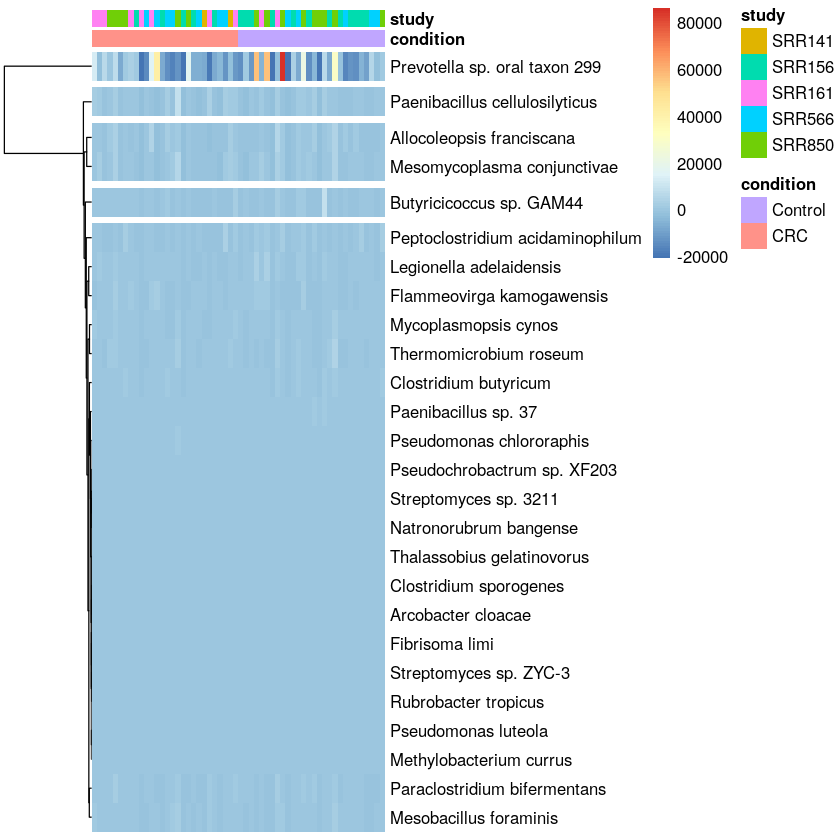

In [101]:
topgenes <- toptable[toptable$qval < 0.03 & toptable$coef < 0,]
topgenes$feature <- gsub('\\.\\.', '--', topgenes$feature)
topgenes$feature <- gsub('\\.', ' ', topgenes$feature)
topgenes$feature <- gsub('\\--', '. ', topgenes$feature)
topgenes$feature <- gsub('\\C 3', 'C-3', topgenes$feature)
mat <- species_adj[topgenes$feature, c(CRC_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata[,c(3,4)], 
         show_colnames = FALSE, cutree_rows=5)

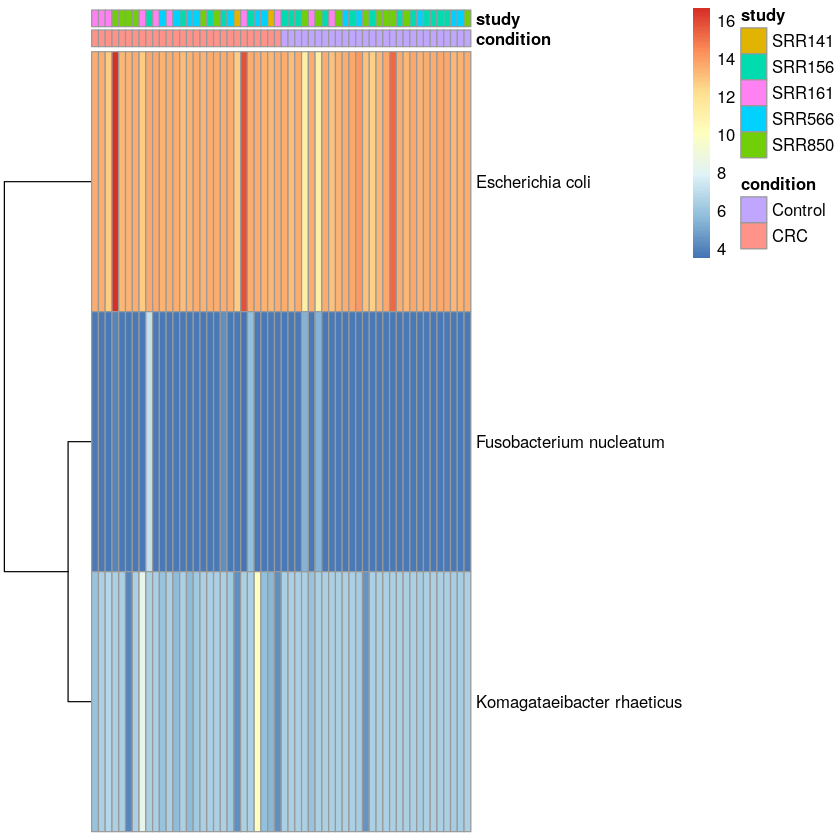

In [108]:
topgenes <- toptable[toptable$qval < 0.03 & toptable$coef > 0,]
topgenes$feature <- gsub('\\.\\.', '--', topgenes$feature)
topgenes$feature <- gsub('\\.', ' ', topgenes$feature)
topgenes$feature <- gsub('\\--', '. ', topgenes$feature)
topgenes$feature <- gsub('\\C 3', 'C-3', topgenes$feature)
mat <- species_adj[topgenes$feature, c(CRC_samples, C_samples)]
mat <- mat - rowMeans(mat)
mat <- log(abs(mat))

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata[,c(3,4)], 
         show_colnames = FALSE)

## DM2

In [109]:
species <- read.delim("merged_bracken_S_DM2.txt")

In [110]:
#Modifiquem nom columnes
tmp <- strsplit(readLines("merged_bracken_S_DM2.txt", n=1), "\t")[[1]]
nms <- tmp[2:length(tmp)]
names(species)[2:length(species)] <- gsub("_bracken_S_num", "", nms)

#Eliminem columnes no necessàries
species <- species[,-c(2,3,seq(5,length(species),2))]
                                          
#Modifiquem nom files
row.names(species) <- species[1:nrow(species),1]
species <- species[,2:length(species)]

#Eliminem files amb 0 per totes les mostres
species <- species[rowSums(species > 0)>0,1:length(species)]

In [111]:
metadata <- read.csv("metadades_DM2.csv")
# reordenem per alinear mostres amb les columnes del arxiu de counts
metadata$sample2 <- metadata$sample
metadata <- left_join(data.frame(sample2 = colnames(species)), metadata)
#canviem nom de files
rownames(metadata) <- metadata$sample
#eliminem columnes no necessàries
metadata <- metadata[1:nrow(metadata),3:length(metadata)]

Joining, by = "sample2"


In [112]:
fit_adjust_batch <- MMUPHin::adjust_batch(feature_abd=species, batch="study",
                                covariates = c("condition"),
                                data = metadata,
                                control = list(verbose=TRUE))
species_adj <- fit_adjust_batch$feature_abd_adj
write.table(species_adj, file = "species_adj_DM2.tsv", sep="\t", row.names=FALSE)

feature_abd is counts

Warning message in check_batch(df_batch[[batch]], min_n_batch = 2):
“Batch variable is not a factor as provided and will be converted to one.”
Found 3 batches

Adjusting for 1 covariate(s) or covariate(s) level(s)

Pseudo count is not specified and set to half of minimal non-zero value: 1e+00

Adjusting for (after filtering) 1161 features

Standardizing data across features

Estimating batch difference parameters and EB priors

Performing shrinkage adjustments on batch difference parameters

Performing batch corrections



In [113]:
maaslin <- Maaslin2(input_data = species_adj,
                    input_metadata = metadata,
                    output = "maaslin2_species_DM2",
                    fixed_effects = c("condition"),
                    random_effects = c("study"),
                    plot_scatter = FALSE,
                     cores = 7)

[1] "Warning: Deleting existing log file: maaslin2_species_DM2/maaslin2.log"
2022-05-16 07:20:18 INFO::Writing function arguments to log file
2022-05-16 07:20:18 INFO::Verifying options selected are valid
2022-05-16 07:20:18 INFO::Determining format of input files
2022-05-16 07:20:18 INFO::Input format is data samples as columns and metadata samples as rows
2022-05-16 07:20:18 INFO::Formula for random effects: expr ~ (1 | study)
2022-05-16 07:20:18 INFO::Formula for fixed effects: expr ~  condition
2022-05-16 07:20:18 INFO::Filter data based on min abundance and min prevalence
2022-05-16 07:20:18 INFO::Total samples in data: 192
2022-05-16 07:20:18 INFO::Min samples required with min abundance for a feature not to be filtered: 19.200000
2022-05-16 07:20:18 INFO::Total filtered features: 822
2022-05-16 07:20:18 INFO::Filtered feature names from abundance and prevalence filtering: Klebsiella.sp..WP3.W18.ESBL.02, Salmonella.sp..SSDFZ54, Citrobacter.braakii, Citrobacter.sp..BIDMC108, Citro

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[1] "There is not enough metadata in the associations to create a heatmap plot. Please review the associations in text output file."


In [114]:
set.seed(42)
DM2_samples <- sample(row.names(metadata)[metadata$condition=="DM2"],28)
C_samples <- sample(row.names(metadata)[metadata$condition=="Control"],28)

In [118]:
toptable <- read.delim("maaslin2_species_DM2/significant_results.tsv")

In [123]:
#0.01
nrow(toptable[toptable$qval < 0.01,])
#0.001
nrow(toptable[toptable$qval < 0.001,])
#0.0001
nrow(toptable[toptable$qval < 0.0001,])
#0.00001
nrow(toptable[toptable$qval < 0.00001,])
#0.000001
nrow(toptable[toptable$qval < 0.000001,])
#0.0000001
nrow(toptable[toptable$qval < 0.0000001,])
#0.00000001
nrow(toptable[toptable$qval < 0.00000001,])

[1] 279

[1] 187

[1] 131

[1] 105

[1] 62

[1] 42

[1] 29

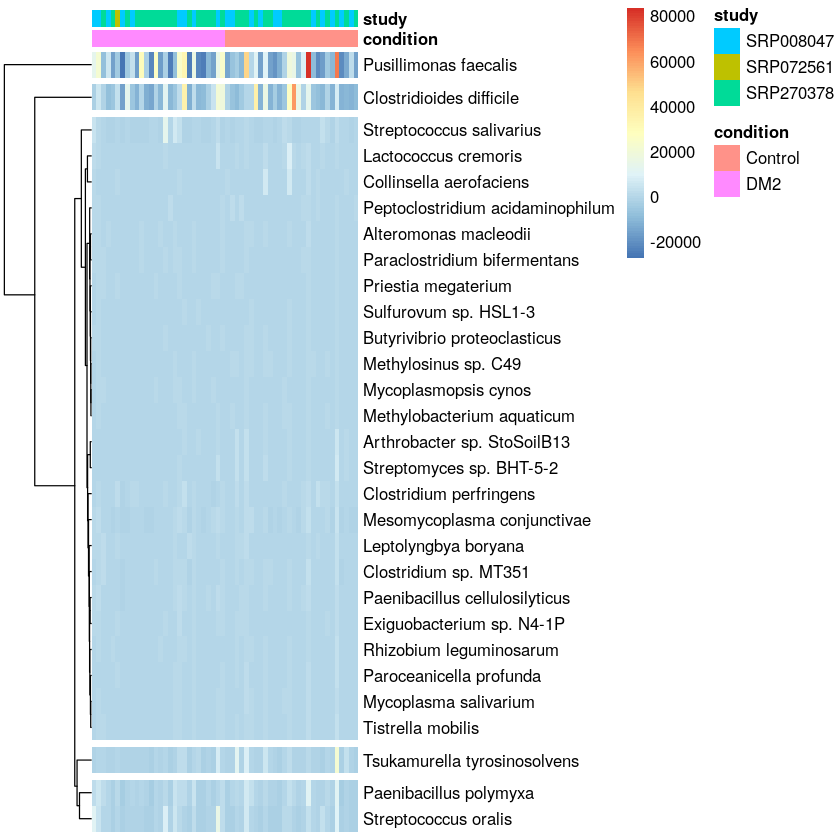

In [138]:
topgenes <- toptable[toptable$qval < 0.00000001,]
topgenes$feature <- gsub('\\.\\.', '--', topgenes$feature)
topgenes$feature <- gsub('\\.', ' ', topgenes$feature)
topgenes$feature <- gsub('\\--', '. ', topgenes$feature)
topgenes$feature <- gsub('\\C 3', 'C-3', topgenes$feature)
topgenes$feature <- gsub('\\T 5 2', 'T-5-2', topgenes$feature)
topgenes$feature <- gsub('\\N4 1P', 'N4-1P', topgenes$feature)
topgenes$feature <- gsub('\\L1 3', 'L1-3', topgenes$feature)
mat <- species_adj[topgenes$feature, c(DM2_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata, 
         show_colnames = FALSE, cutree_rows=5)

## PD

In [141]:
species <- read.delim("merged_bracken_S_PD.txt")

In [142]:
#Modifiquem nom columnes
tmp <- strsplit(readLines("merged_bracken_S_PD.txt", n=1), "\t")[[1]]
nms <- tmp[2:length(tmp)]
names(species)[2:length(species)] <- gsub("_bracken_S_num", "", nms)

#Eliminem columnes no necessàries
species <- species[,-c(2,3,seq(5,length(species),2))]
                                          
#Modifiquem nom files
row.names(species) <- species[1:nrow(species),1]
species <- species[,2:length(species)]

#Eliminem files amb 0 per totes les mostres
species <- species[rowSums(species > 0)>0,1:length(species)]

In [159]:
metadata <- read.csv("metadades_PD.csv", fileEncoding="iso-8859-1")
# reordenem per alinear mostres amb les columnes del arxiu de counts
metadata$sample2 <- metadata$sample
metadata <- left_join(data.frame(sample2 = colnames(species)), metadata)
#canviem nom de files
rownames(metadata) <- metadata$sample
#eliminem columnes no necessàries
metadata <- metadata[1:nrow(metadata),3:length(metadata)]

Joining, by = "sample2"


In [144]:
fit_adjust_batch <- MMUPHin::adjust_batch(feature_abd=species, batch="study",
                                covariates = c("condition"),
                                data = metadata,
                                control = list(verbose=TRUE))
species_adj <- fit_adjust_batch$feature_abd_adj
write.table(species_adj, file = "species_adj_PD.tsv", sep="\t", row.names=FALSE)

feature_abd is counts

Warning message in check_batch(df_batch[[batch]], min_n_batch = 2):
“Batch variable is not a factor as provided and will be converted to one.”
Found 2 batches

Adjusting for 1 covariate(s) or covariate(s) level(s)

Pseudo count is not specified and set to half of minimal non-zero value: 1e+00

Adjusting for (after filtering) 989 features

Standardizing data across features

Estimating batch difference parameters and EB priors

Performing shrinkage adjustments on batch difference parameters

Performing batch corrections



In [145]:
maaslin <- Maaslin2(input_data = species_adj,
                    input_metadata = metadata,
                    output = "maaslin2_species_PD",
                    fixed_effects = c("condition"),
                    random_effects = c("study"),
                    plot_scatter = FALSE,
                     cores = 7)

[1] "Creating output folder"
[1] "Creating output figures folder"
2022-05-16 07:31:39 INFO::Writing function arguments to log file
2022-05-16 07:31:39 INFO::Verifying options selected are valid
2022-05-16 07:31:39 INFO::Determining format of input files
2022-05-16 07:31:39 INFO::Input format is data samples as columns and metadata samples as rows
2022-05-16 07:31:39 INFO::Formula for random effects: expr ~ (1 | study)
2022-05-16 07:31:39 INFO::Formula for fixed effects: expr ~  condition
2022-05-16 07:31:39 INFO::Filter data based on min abundance and min prevalence
2022-05-16 07:31:39 INFO::Total samples in data: 136
2022-05-16 07:31:39 INFO::Min samples required with min abundance for a feature not to be filtered: 13.600000
2022-05-16 07:31:39 INFO::Total filtered features: 809
2022-05-16 07:31:39 INFO::Filtered feature names from abundance and prevalence filtering: Corynebacterium.marinum, Streptomyces.anulatus, Mycoplasma.orale, Cardinium.endosymbiont.of.Bemisia.tabaci, Marinobacte

In [146]:
set.seed(42)
PD_samples <- sample(row.names(metadata)[metadata$condition=="PD"],28)
C_samples <- sample(row.names(metadata)[metadata$condition=="Control"],28)

In [147]:
toptable <- read.delim("maaslin2_species_PD/significant_results.tsv")

In [152]:
#0.05
nrow(toptable[toptable$qval < 0.05,])
nrow(toptable)

[1] 4

[1] 24

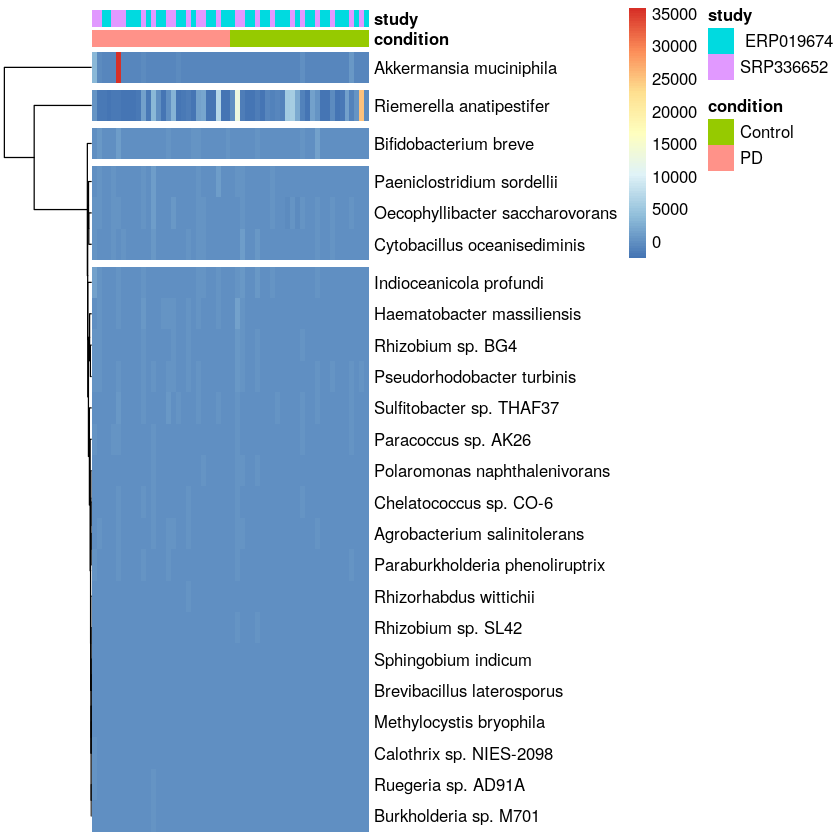

In [161]:
topgenes <- toptable
topgenes$feature <- gsub('\\.\\.', '--', topgenes$feature)
topgenes$feature <- gsub('\\.', ' ', topgenes$feature)
topgenes$feature <- gsub('\\--', '. ', topgenes$feature)
topgenes$feature <- gsub('\\C 3', 'C-3', topgenes$feature)
topgenes$feature <- gsub('\\T 5 2', 'T-5-2', topgenes$feature)
topgenes$feature <- gsub('\\N4 1P', 'N4-1P', topgenes$feature)
topgenes$feature <- gsub('\\L1 3', 'L1-3', topgenes$feature)
topgenes$feature <- gsub('\\NIES 20', 'NIES-20', topgenes$feature)
topgenes$feature <- gsub('\\CO 6', 'CO-6', topgenes$feature)
mat <- species_adj[topgenes$feature, c(PD_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata, 
         show_colnames = FALSE, cutree_rows=5)

In [165]:
topgenes

feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
Methylocystis bryophila,condition,PD,1.5301289,0.3263879,136,33,6.740405e-06,0.004817845
Akkermansia muciniphila,condition,PD,2.7957361,0.6138503,136,61,1.167962e-05,0.004817845
Sulfitobacter sp. THAF37,condition,PD,1.4597172,0.3752908,136,97,1.574411e-04,0.032472234
Sphingobium indicum,condition,PD,0.5889905,0.1504889,136,16,1.443378e-04,0.032472234
Paeniclostridium sordellii,condition,PD,1.0420676,0.2822508,136,61,3.236329e-04,0.053399426
Riemerella anatipestifer,condition,PD,-1.4378090,0.4026079,136,132,4.941157e-04,0.067940911
Oecophyllibacter saccharovorans,condition,PD,0.7549916,0.2325965,136,134,1.480211e-03,0.138190001
Bifidobacterium breve,condition,PD,1.7892036,0.5521392,136,74,1.507527e-03,0.138190001
Brevibacillus laterosporus,condition,PD,0.5585055,0.1685837,136,15,1.189301e-03,0.138190001


In [155]:
intersect(topgenes$feature, row.names(species_adj))

[1] "Methylocystis bryophila"         "Akkermansia muciniphila"        
 [3] "Sulfitobacter sp. THAF37"        "Sphingobium indicum"            
 [5] "Paeniclostridium sordellii"      "Riemerella anatipestifer"       
 [7] "Oecophyllibacter saccharovorans" "Bifidobacterium breve"          
 [9] "Brevibacillus laterosporus"      "Indioceanicola profundi"        
[11] "Haematobacter massiliensis"      "Ruegeria sp. AD91A"             
[13] "Agrobacterium salinitolerans"    "Cytobacillus oceanisediminis"   
[15] "Paraburkholderia phenoliruptrix" "Rhizobium sp. BG4"              
[17] "Pseudorhodobacter turbinis"      "Burkholderia sp. M701"          
[19] "Polaromonas naphthalenivorans"   "Rhizobium sp. SL42"             
[21] "Paracoccus sp. AK26"             "Rhizorhabdus wittichii"

In [156]:
length(intersect(topgenes$feature, row.names(species_adj)))

[1] 22